In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
%matplotlib inline

/Users/prudhvivuda/.virtualenvs/genai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
df = pd.read_csv('weatherHistory.csv')
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True).dt.tz_localize(None)  # Remove timezone
df = df.sort_values('Formatted Date')

# Extract first 4000 hours
input_data = df[['Formatted Date', 'Temperature (C)']].iloc[:8000]
actual_next_month = df[['Formatted Date', 'Temperature (C)']].iloc[8000:8000+744]

# Prepare for Prophet
prophet_data = input_data.rename(columns={'Formatted Date': 'ds', 'Temperature (C)': 'y'})

# Verify no timezone in ds
print("Timezone check:", prophet_data['ds'].dt.tz is None)  # Should print True
print("\nSample input data:")
print(prophet_data.head())
print("\nSample actual data for next month:")
print(actual_next_month.head())

Timezone check: True

Sample input data:
                      ds         y
2880 2005-12-31 23:00:00  0.577778
2881 2006-01-01 00:00:00  1.161111
2882 2006-01-01 01:00:00  1.666667
2883 2006-01-01 02:00:00  1.711111
2884 2006-01-01 03:00:00  1.183333

Sample actual data for next month:
          Formatted Date  Temperature (C)
7135 2006-11-30 07:00:00         5.994444
7136 2006-11-30 08:00:00         6.016667
7137 2006-11-30 09:00:00         6.933333
7138 2006-11-30 10:00:00         7.150000
7139 2006-11-30 11:00:00         7.222222


In [4]:
# Fit Prophet model
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05  # Adjust for flexibility
)
model.fit(prophet_data)

# Predict next 744 hours
future = model.make_future_dataframe(periods=744, freq='H')
forecast = model.predict(future)
predictions = forecast[['ds', 'yhat']].iloc[-744:]

# Rename columns for consistency
predictions = predictions.rename(columns={'ds': 'Formatted Date', 'yhat': 'Temperature (C)_predicted'})

# Ensure predictions are timezone-naive
predictions['Formatted Date'] = predictions['Formatted Date'].dt.tz_localize(None)

# Display sample predictions
print("Sample predictions:")
print(predictions.head())

12:04:09 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing
/Users/prudhvivuda/.virtualenvs/genai/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Sample predictions:
          Formatted Date  Temperature (C)_predicted
8000 2006-11-30 07:00:00                   4.250938
8001 2006-11-30 08:00:00                   5.726397
8002 2006-11-30 09:00:00                   6.902557
8003 2006-11-30 10:00:00                   7.702854
8004 2006-11-30 11:00:00                   8.232894


Prophet MAE: 22.56°C
Prophet RMSE: 25.61°C
Prophet MAPE: inf%


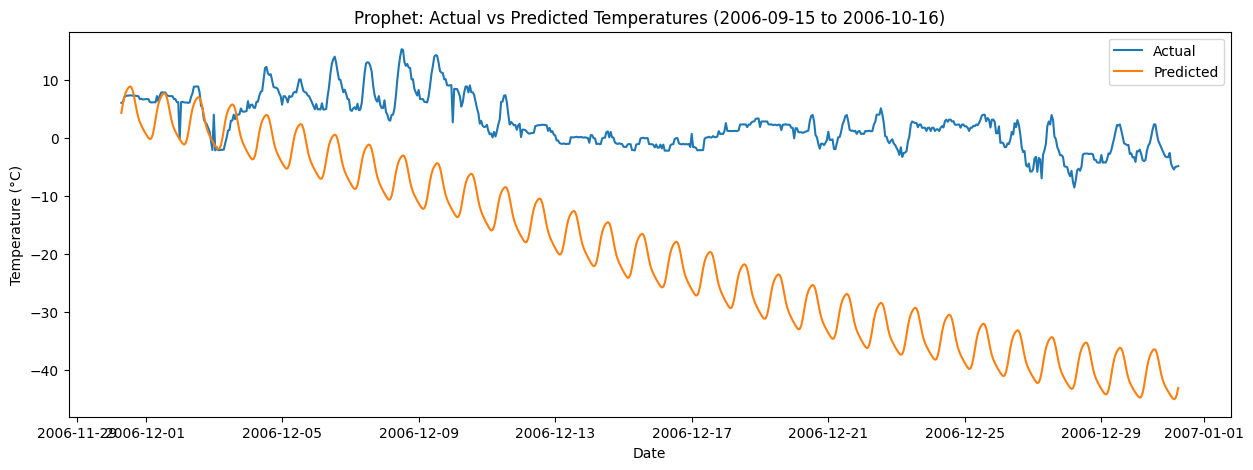

In [5]:
# Compare with actual data
comparison = actual_next_month.merge(
    predictions,
    on='Formatted Date'
)

# Calculate metrics
mae = mean_absolute_error(
    comparison['Temperature (C)'],
    comparison['Temperature (C)_predicted']
)
rmse = np.sqrt(mean_squared_error(
    comparison['Temperature (C)'],
    comparison['Temperature (C)_predicted']
))
mape = np.mean(np.abs(
    (comparison['Temperature (C)'] - comparison['Temperature (C)_predicted']) /
    comparison['Temperature (C)']
)) * 100

print(f"Prophet MAE: {mae:.2f}°C")
print(f"Prophet RMSE: {rmse:.2f}°C")
print(f"Prophet MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(15, 5))
plt.plot(comparison['Formatted Date'], comparison['Temperature (C)'], label='Actual')
plt.plot(comparison['Formatted Date'], comparison['Temperature (C)_predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Prophet: Actual vs Predicted Temperatures (2006-09-15 to 2006-10-16)')
plt.legend()
plt.show()

In [6]:
import pandas as pd

# Load the dataset
data = pd.read_csv('weatherHistory.csv')

# Convert 'Formatted Date' to datetime and sort
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data = data.sort_values('Formatted Date')

# Extract relevant columns
temperature_data = data[['Formatted Date', 'Temperature (C)']]

# Rename columns for Prophet
temperature_data = temperature_data.rename(columns={
    'Formatted Date': 'ds',  # Prophet requires 'ds' for timestamps
    'Temperature (C)': 'y'   # Prophet requires 'y' for values
})

# Remove timezone information
temperature_data['ds'] = temperature_data['ds'].dt.tz_localize(None)

# Ensure the data is sorted by date
temperature_data = temperature_data.sort_values('ds')

In [7]:
from prophet import Prophet

# Initialize Prophet model
model = Prophet(
    daily_seasonality=True,  # Enable daily seasonality
    weekly_seasonality=False,  # Disable weekly seasonality (not relevant for weather)
    yearly_seasonality=True,  # Enable yearly seasonality
    changepoint_prior_scale=0.05  # Control flexibility of trend changes
)

# Fit the model on the first year of data
one_year_data = temperature_data.iloc[:8760]  # First 8,760 rows correspond to 1 year of hourly data
model.fit(one_year_data)

12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=720, freq='H')  # Predict next 720 hours (30 days)

# Generate predictions
forecast = model.predict(future)

# Extract predicted temperatures
next_month_predictions = forecast[['ds', 'yhat']].tail(720)  # Last 720 rows correspond to next month

# Extract actual temperatures for the next month
actual_next_month = temperature_data.iloc[8760:9480]  # Next 720 rows correspond to next month

# Merge actual and predicted data
comparison = pd.merge(
    actual_next_month,
    next_month_predictions,
    on='ds',
    how='inner'
).rename(columns={'y': 'Actual', 'yhat': 'Predicted'})

/Users/prudhvivuda/.virtualenvs/genai/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


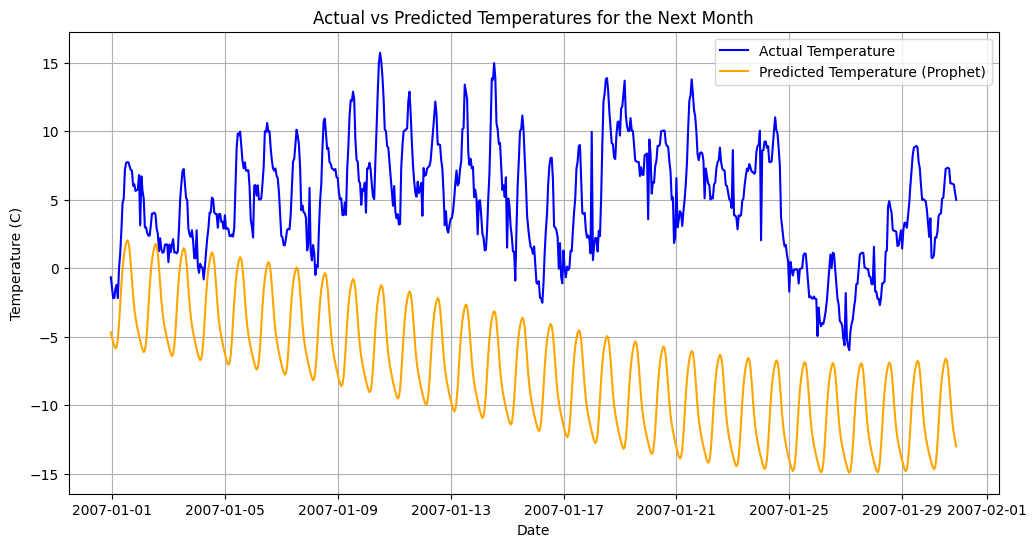

TypeError: got an unexpected keyword argument 'squared'

In [9]:
# Plot actual vs predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['Actual'], label='Actual Temperature', color='blue')
plt.plot(comparison['ds'], comparison['Predicted'], label='Predicted Temperature (Prophet)', color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Actual vs Predicted Temperatures for the Next Month')
plt.legend()
plt.grid(True)
plt.show()

# Compute evaluation metrics
mae = mean_absolute_error(comparison['Actual'], comparison['Predicted'])
rmse = mean_squared_error(comparison['Actual'], comparison['Predicted'], squared=False)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")